In [1]:
from transformers import AutoProcessor, AutoModelForCausalLM
from PIL import Image, ImageDraw, ImageFont 
import requests
import copy
import os
import random
import numpy as np

%matplotlib inline

/Users/sarathmenon/llm_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from transformers.dynamic_module_utils import get_imports
from unittest.mock import patch

def fixed_get_imports(filename: str | os.PathLike) -> list[str]:
    """Work around for https://huggingface.co/microsoft/phi-1_5/discussions/72."""
    if not str(filename).endswith("/modeling_florence2.py"):
        return get_imports(filename)
    imports = get_imports(filename)
    imports.remove("flash_attn")
    return imports

In [6]:
model_id = 'microsoft/Florence-2-base-ft'
# model_id = "/Users/sarathmenon/Documents/master_thesis/clicking_server/Florence-2-base-ft"
images_path = "../datasets/resized_media/gameplay_images"

with patch("transformers.dynamic_module_utils.get_imports", fixed_get_imports):
        model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True)
        processor = AutoProcessor.from_pretrained(model_id, trust_remote_code=True)

/Users/sarathmenon/.cache/huggingface/modules/transformers_modules/Florence-2-base-ft/processing_florence2.py:499: SyntaxWarning: invalid escape sequence '\d'
  """


In [9]:
colormap = ['blue','orange','green','purple','brown','pink','gray','olive','cyan','red',
            'lime','indigo','violet','aqua','magenta','coral','gold','tan','skyblue']

def run_example(task_prompt, text_input=None):
    if text_input is None:
        prompt = task_prompt
    else:
        prompt = task_prompt + text_input
    inputs = processor(text=prompt, images=image, return_tensors="pt")
    generated_ids = model.generate(
      input_ids=inputs["input_ids"],
      pixel_values=inputs["pixel_values"],
      max_new_tokens=1024,
      early_stopping=False,
      do_sample=False,
      num_beams=3,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=False)[0]
    parsed_answer = processor.post_process_generation(
        generated_text,
        task=task_prompt,
        image_size=(image.width, image.height)
    )

    return parsed_answer

import matplotlib.pyplot as plt
import matplotlib.patches as patches
def plot_bbox(image, data):
   # Create a figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(image)

    # Plot each bounding box
    for bbox, label in zip(data['bboxes'], data['labels']):
        # Unpack the bounding box coordinates
        x1, y1, x2, y2 = bbox
        # Create a Rectangle patch
        rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor='r', facecolor='none')
        # Add the rectangle to the Axes
        ax.add_patch(rect)
        # Annotate the label
        plt.text(x1, y1, label, color='white', fontsize=8, bbox=dict(facecolor='red', alpha=0.5))

    # Remove the axis ticks and labels
    ax.axis('off')


    # Show the plot
    plt.show()

def convert_to_od_format(data):  
    """  
    Converts a dictionary with 'bboxes' and 'bboxes_labels' into a dictionary with separate 'bboxes' and 'labels' keys.  
  
    Parameters:  
    - data: The input dictionary with 'bboxes', 'bboxes_labels', 'polygons', and 'polygons_labels' keys.  
  
    Returns:  
    - A dictionary with 'bboxes' and 'labels' keys formatted for object detection results.  
    """  
    # Extract bounding boxes and labels  
    bboxes = data.get('bboxes', [])  
    labels = data.get('bboxes_labels', [])  
      
    # Construct the output format  
    od_results = {  
        'bboxes': bboxes,  
        'labels': labels  
    }  
      
    return od_results  

def draw_ocr_bboxes(image, prediction):
    scale = 1
    draw = ImageDraw.Draw(image)
    bboxes, labels = prediction['quad_boxes'], prediction['labels']
    for box, label in zip(bboxes, labels):
        color = random.choice(colormap)
        new_box = (np.array(box) * scale).tolist()
        draw.polygon(new_box, width=3, outline=color)
        draw.text((new_box[0]+8, new_box[1]+2),
                    "{}".format(label),
                    align="right",
        
                    fill=color)
    display(image)

# OCR

In [9]:
image = Image.open(images_path + "/captain_toad/1.jpg").convert("RGB")

task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results['<OCR_WITH_REGION>']['labels'])
draw_ocr_bboxes(image, results['<OCR_WITH_REGION>'])

FileNotFoundError: [Errno 2] No such file or directory: '/Users/sarathmenon/Documents/master_thesis/datasets/resized_media/gameplay_images/captain_toad/1.jpg'

[]


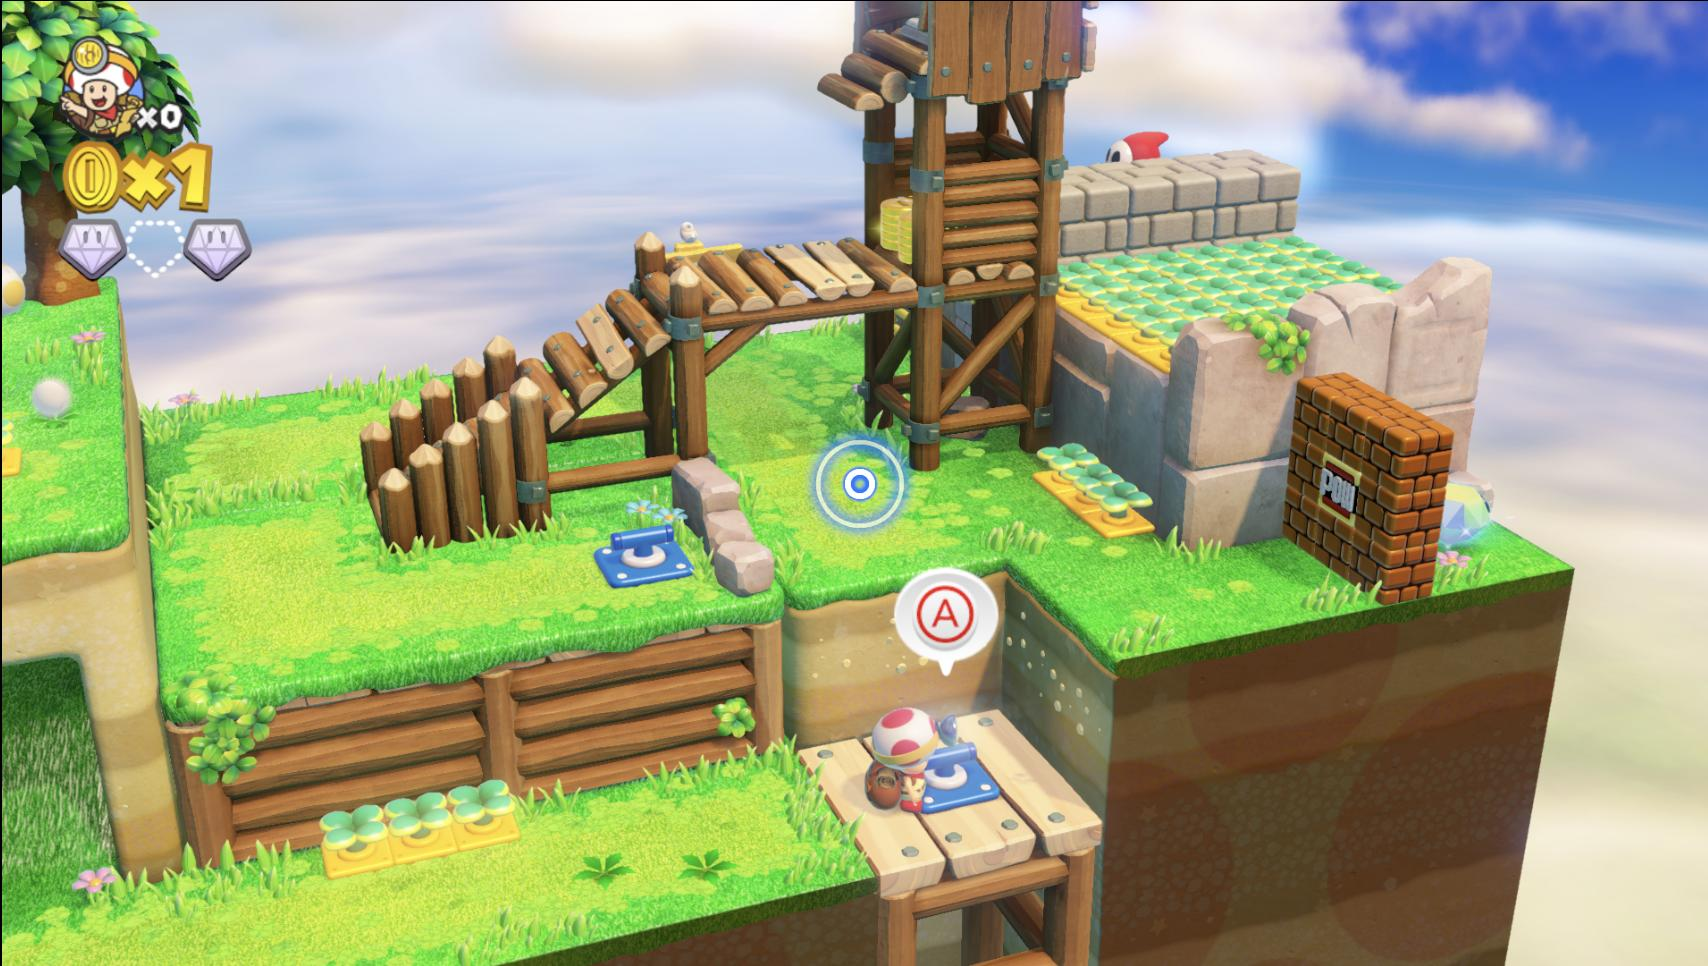

In [ ]:
image = Image.open(images_path + "/captain_toad/2.jpeg").convert("RGB")

task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results['<OCR_WITH_REGION>']['labels'])
draw_ocr_bboxes(image, results['<OCR_WITH_REGION>'])

['Plucky Pass', 'Beginnings', 'Continue Playing', 'Exit Course', '?']


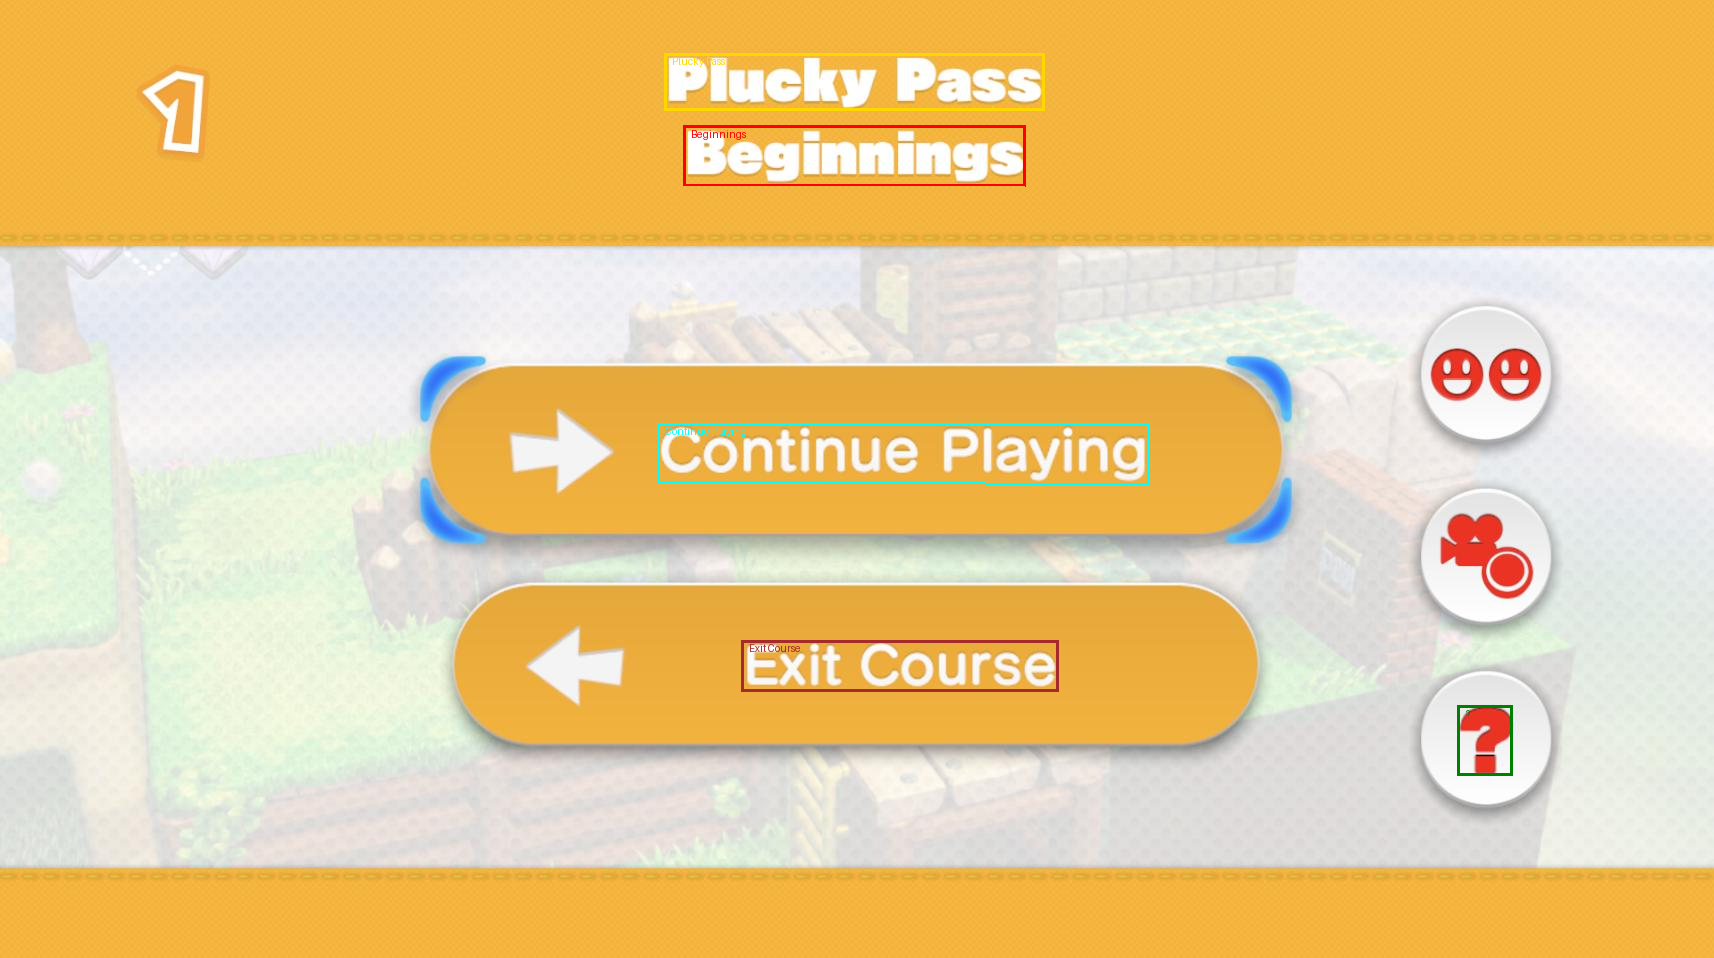

In [ ]:
image = Image.open(images_path + "/captain_toad/3.jpeg").convert("RGB")

task_prompt = '<OCR_WITH_REGION>'
results = run_example(task_prompt)
print(results['<OCR_WITH_REGION>']['labels'])
draw_ocr_bboxes(image, results['<OCR_WITH_REGION>'])

In [15]:
images_path = "../datasets/resized_media/gameplay_images"

# Mario

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[0.8640000224113464, 247.41549682617188, 1725.4080810546875, 1065.0594482421875]], 'labels': ['pillars']}}


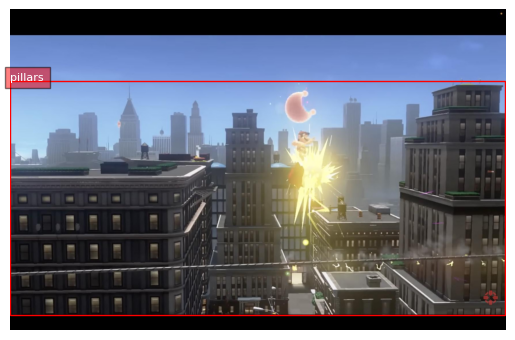

In [16]:
image = Image.open(images_path + "/mario_odessey/0.jpg")

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="pillars.")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

# Hogwarts legacy

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[1156.89599609375, 507.6764831542969, 1286.49609375, 665.1734619140625]], 'labels': ['hat']}}


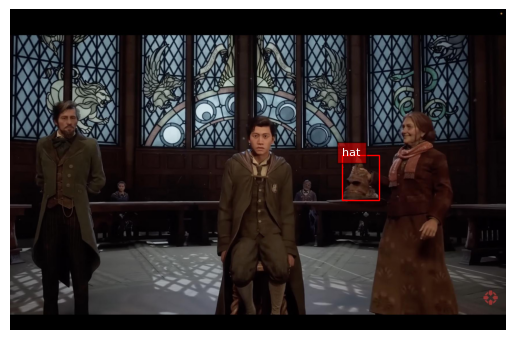

In [7]:
image = Image.open(images_path + "/hogwarts_legacy/1.jpg")

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="hat.")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

## Unpacking

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[512.3519897460938, 452.9434814453125, 709.343994140625, 639.4824829101562], [619.488037109375, 641.7164916992188, 871.7760009765625, 967.8804931640625], [1004.83203125, 437.30548095703125, 1236.384033203125, 595.9194946289062], [799.2000122070312, 466.3475036621094, 1039.3919677734375, 658.4714965820312]], 'labels': ['computer', 'chair', 'pillow', 'open box']}}


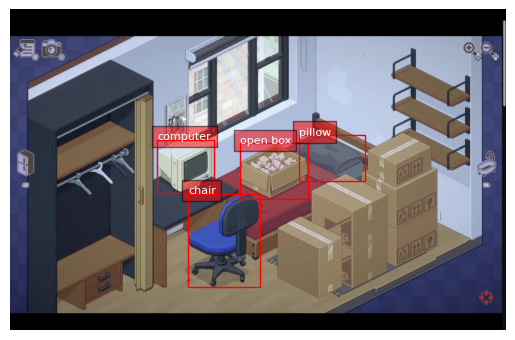

In [147]:
image = Image.open(images_path + "/unpacking/0.jpg")

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="computer. chair. pillow. open box.")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[1191.4560546875, 433.9544982910156, 1543.968017578125, 855.0634765625], [171.93600463867188, 623.844482421875, 356.8320007324219, 839.4254760742188]], 'labels': ['oven', 'trash can']}}


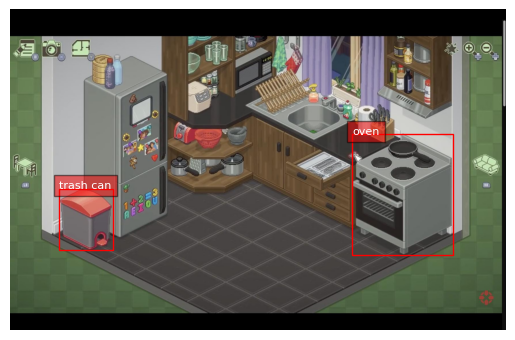

In [155]:
image = Image.open(images_path + "/unpacking/6.jpg")

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="oven. trash can.")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

## Fortnite

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[149.4720001220703, 469.698486328125, 365.4720153808594, 647.301513671875], [648.864013671875, 607.0894775390625, 752.5440063476562, 780.2244873046875]], 'labels': ['box', 'box']}}


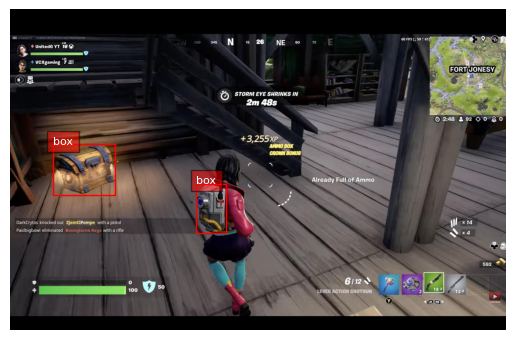

In [37]:
image = Image.open(images_path + "/fortnite/3.jpg")

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="box.")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])

{'<CAPTION_TO_PHRASE_GROUNDING>': {'bboxes': [[569.3760375976562, 458.52850341796875, 690.3359985351562, 638.365478515625]], 'labels': ['barrel']}}


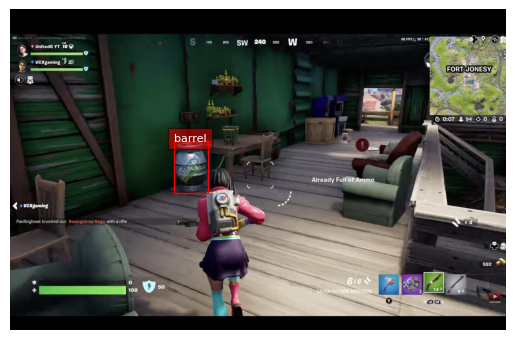

In [45]:
image = Image.open(images_path + "/fortnite/4.jpg")

task_prompt = '<CAPTION_TO_PHRASE_GROUNDING>'
results = run_example(task_prompt, text_input="barrel.")
print(results)
plot_bbox(image, results['<CAPTION_TO_PHRASE_GROUNDING>'])